<a href="https://colab.research.google.com/github/ChristianBarrington/Data/blob/master/TrafficSignCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
    
print(type(train_data))
X_train, Y_train = train_data['features'], train_data['labels']
X_val, Y_val = val_data['features'], val_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == Y_train.shape[0]),'The number of images is not equal to the number of labels'
assert(X_val.shape[0] == Y_val.shape[0]),'The number of images is not equal to the number of labels'
assert(X_test.shape[0] == Y_test.shape[0]),'The number of images is not equal to the number of labels'
assert(X_train.shape[1:] == (32,32,3)), 'The dimensions of images are not 32 x 32 x 3'
assert(X_val.shape[1:] == (32,32,3)), 'The dimensions of images are not 32 x 32 x 3'
assert(X_test.shape[1:] == (32,32,3)), 'The dimensions of images are not 32 x 32 x 3'



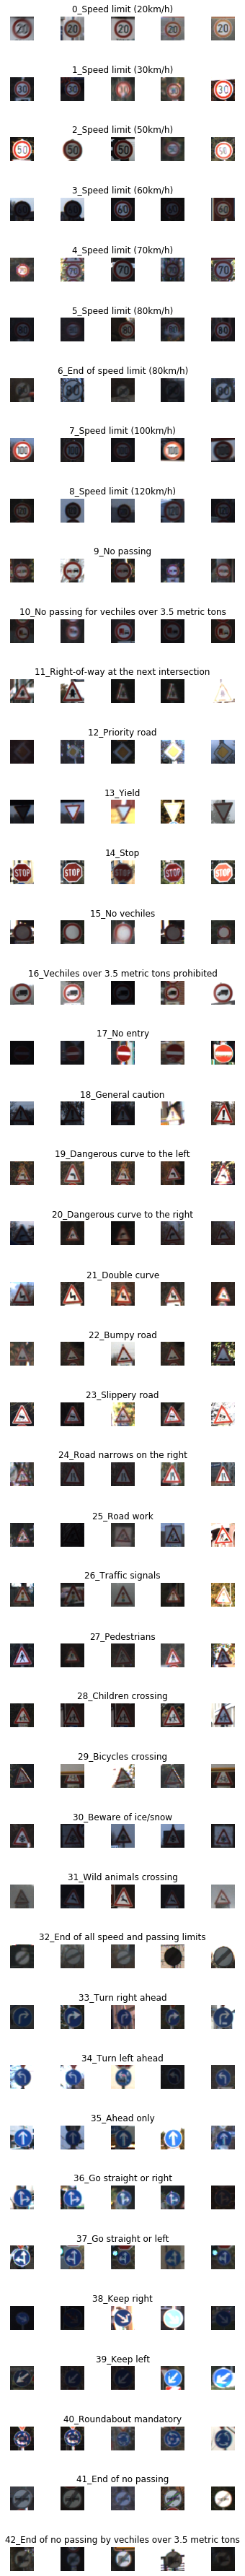

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row  in data.iterrows():
        x_selected = X_train[Y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '_' + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

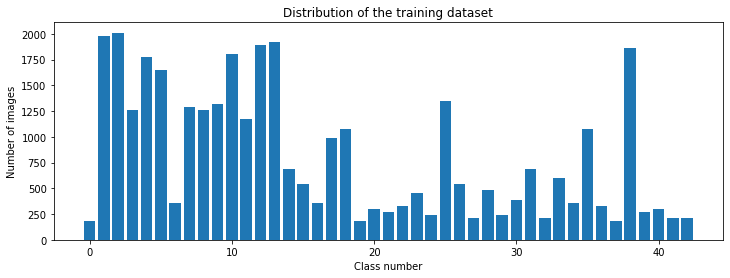

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


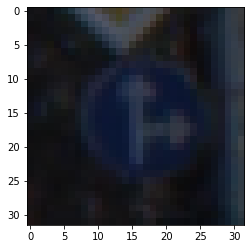

In [11]:
import cv2
plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(Y_train[1000])

(32, 32)


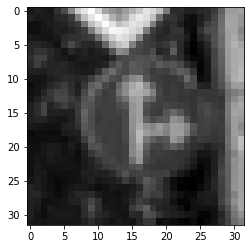

In [12]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

(32, 32)


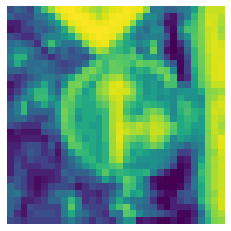

In [13]:
def equalise(img):
  img = cv2.equalizeHist(img)
  return img

img = equalise(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalise(img)
  img = img/255
  return img
  

In [0]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))



(34799, 32, 32)


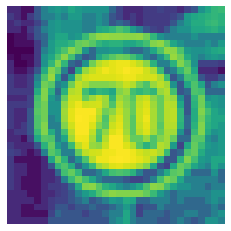

In [16]:
plt.imshow(X_train[random.randint(0,len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [17]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410,32,32,1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(X_train)

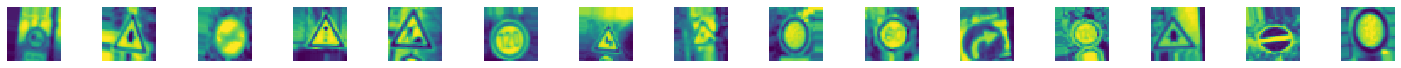

In [19]:
batches = datagen.flow(X_train, Y_train, batch_size = 20)
X_batch, Y_batch = next(batches)
fig, axs = plt.subplots(1,15,figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
Y_train = to_categorical(Y_train, 43)
Y_test = to_categorical(Y_test, 43)
Y_val = to_categorical(Y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(80,(5,5), input_shape = (32,32,1), activation = 'relu'))
  model.add(Conv2D(40,(5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Conv2D(50,(3,3), activation = 'relu'))
  model.add(Conv2D(50,(3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  model.compile(Adam(lr = 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [22]:
model = modified_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 80)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        80040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 40)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 50)        18050     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 50)          22550     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 50)          0        

In [23]:
h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (X_val, Y_val), shuffle = 1 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2000/2000 [==============================] - 70s 35ms/step - loss: 0.8692 - acc: 0.7440 - val_loss: 0.0608 - val_acc: 0.9816
Epoch 2/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.1745 - acc: 0.9456 - val_loss: 0.0341 - val_acc: 0.9905
Epoch 3/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1180 - acc: 0.9626 - val_loss: 0.0325 - val_acc: 0.9889
Epoch 4/10
2000/2000 [==============================] - 57s 28ms/step - loss: 0.0891 - acc: 0.9725 - val_loss: 0.0363 - val_acc: 0.9898
Epoch 5/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0723 - acc: 0.9778 - val_loss: 0.0338 - val_acc: 0.9900
Epoch 6/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0663 - acc: 0.9795 - val_loss: 0.0257 - val_acc: 0.9921
Epoch 7/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.05

Text(0.5, 0, 'epoch')

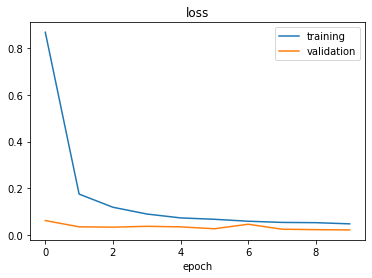

In [24]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

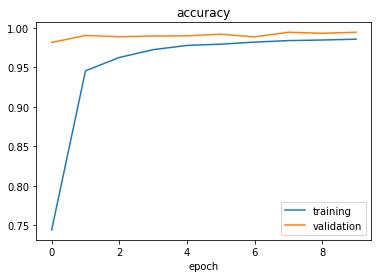

In [25]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['training','validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [26]:
score = model.evaluate(X_test,Y_test,verbose = 0)
print('Test Score:', score[0])
print('Test accuracy:', score[1])

Test Score: 0.0966821427004266
Test accuracy: 0.9779097387645326


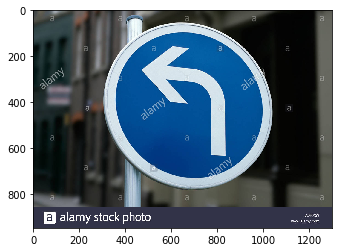

In [31]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 


(32, 32)


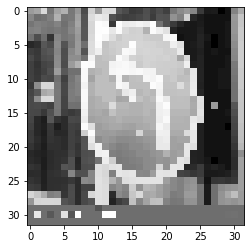

In [32]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 


In [33]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [34]


In [34]:
model